In [2]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [4]:
#Reading CSV's
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [5]:
#SalePrice Data Info
describe_train = train.SalePrice.describe()
describe_train

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Train skew:  1.8828757597682129


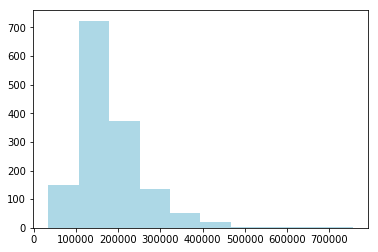

In [6]:
#Finding Train Skew
print ("Train skew: ", train.SalePrice.skew())
plt.hist(train.SalePrice, color='lightblue')
plt.show()

Target skew:  0.12133506220520406


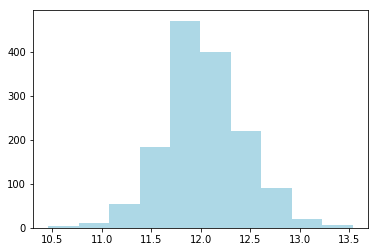

In [7]:
#Finding Target Skew
target = np.log(train.SalePrice)
print ("Target skew: ", target.skew())
plt.hist(target, color='lightblue')
plt.show()

In [24]:
#Finding Graph Correlations
numeric_features = train.select_dtypes(include=[np.number])
correlation = numeric_features.corr()
first_comparator = correlation['SalePrice'].sort_values(ascending=False)[:5]
second_comparator = correlation['SalePrice'].sort_values(ascending=False)[-5:]
print ("First values \n", first_comparator, "\n")
print ("Second values \n", second_comparator)

First values 
 SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
Name: SalePrice, dtype: float64 

Second values 
 YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64


In [ ]:
#Categories
categories = train.select_dtypes(exclude=[np.number])
print (categories.describe())

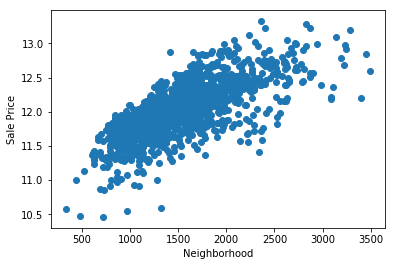

In [26]:
#Removing Outliers from Selected Index
train = train[train['GrLivArea'] < 3500]
plt.scatter(x = train['GrLivArea'], y = np.log(train.SalePrice))
plt.ylabel('Sale Price')
plt.xlabel('GrLivArea')
plt.show()

In [27]:
#Handling Nulls
nulls = pd.DataFrame(train.isnull().sum().sort_values(ascending=False)[:25])
nulls.columns = ['Null Count']
nulls.index.name = 'Feature'
print(nulls)

              Null Count
Feature                 
PoolQC              1449
MiscFeature         1400
Alley               1363
Fence               1175
FireplaceQu          690
LotFrontage          259
GarageQual            81
GarageCond            81
GarageFinish          81
GarageType            81
GarageYrBlt           81
BsmtExposure          38
BsmtFinType2          38
BsmtQual              37
BsmtCond              37
BsmtFinType1          37
MasVnrArea             8
MasVnrType             8
Electrical             1
RoofStyle              0
RoofMatl               0
ExterQual              0
Exterior1st            0
Exterior2nd            0
YearBuilt              0


In [28]:
#Interpolate missing data with an average value
data = train.select_dtypes(include=[np.number]).interpolate().dropna()

In [29]:
#Linear Model, Splitting the Test Size For a More Accurate Prediction
y = np.log(train.SalePrice)
X = data.drop(['SalePrice', 'Id'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)
lr = linear_model.LinearRegression()

In [30]:
#Fitting the Linear Regression Model
lin_reg = lr.fit(X_train, y_train)

In [31]:
#Test
model = lin_reg.score(X_test, y_test)
model

0.9060048873726508

In [32]:
#Predictions, RMSE
y_pred = lin_reg.predict(X_test)
pred = mean_squared_error(y_test, y_pred)
pred

0.014658065733951653

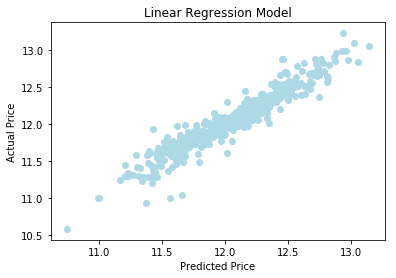

In [33]:
#Graphing the Model
val = y_test
plt.scatter(y_pred, val, color = 'lightblue')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [34]:
#Creating Final Predictions and the Data Frame to Submit
final = pd.DataFrame()
final['Id'] = test.Id
features = test.select_dtypes(include = [np.number]).drop(['Id'], axis = 1).interpolate()
predictions = lin_reg.predict(features)
final_predictions = np.exp(predictions)
print ("Original: ", predictions[:10], "\n")
print ("Final Predictions: ", final_predictions[:10])

Original:  [11.73768338 11.58744008 12.07912945 12.20152263 12.09864486 12.06741928
 12.13954119 12.00671262 12.19957797 11.66398962] 

Final Predictions:  [125201.95847764 107736.10938799 176156.74139999 199092.06302665
 179628.27523755 174105.94573496 187126.69750273 163850.9767593
 198705.27290978 116307.12679164]


In [35]:
final['SalePrice'] = final_predictions
final.to_csv('Submission1.csv', index=False)
final

,Id,SalePrice
0,1461,125201.958478
1,1462,107736.109388
2,1463,176156.741400
3,1464,199092.063027
4,1465,179628.275238
5,1466,174105.945735
6,1467,187126.697503
7,1468,163850.976759
8,1469,198705.272910
9,1470,116307.126792
